In [1]:
from TargetImage import TargetImage
from InputImage import InputImage
import numpy as np
# from matplotlib import pyplot as plt
# import matplotlib.image as mpimg
# from matplotlib.patches import Circle
# from collections.abc import Iterable
# from IPython.display import clear_output

In [2]:
# load static parameters

# load internal parameters of camera
ip = np.array([[2759.48, 0,       1520.69],
               [0,       2764.16, 1006.81],
               [0,       0,       1      ]])

# load external parameters of camera
ep_l = np.array([[0.994915,    -0.100715,  0.00117536],
                 [-0.00462005, -0.0339759, 0.999412  ],
                 [-0.100616,   -0.994335,  -0.0342684]])
ep_m = np.array([[0.962742,   -0.270399,  0.00344709],
                 [-0.0160548, -0.0444283, 0.998884  ],
                 [-0.269944,  -0.961723,  -0.0471142]])
ep_r = np.array([[0.890856,   -0.454283,  -0.00158434],
                 [-0.0211638, -0.0449857, 0.998763   ],
                 [-0.453793,  -0.889721,  -0.0496901 ]])

# load camera positions
cmpos_l = np.array([-15.8818, -3.15083, 0.0592619])
cmpos_m = np.array([-14.1604, -3.32084, 0.0862032])
cmpos_r = np.array([-12.404,  -3.81315, 0.110559 ])

# load picture resolution
resolution = (3072, 2048)

# load 3D bounds
bound_l = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_m = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_r = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))

# cord for testing
cord = (-15.0744, -11.9719, -1.79769)

In [3]:
leftImage = InputImage("./data/0006.png", ep=ep_l, cp=cmpos_l, bound=bound_l)
rightImage = InputImage('./data/0004.png', ep=ep_r, cp=cmpos_r, bound=bound_r)
targetImage = TargetImage(
    ep=ep_m, cp=cmpos_m, bound=bound_m,
    path="./data/0005.png", 
    groundTruthPath="./data/fountain.ply")
# leftImage.show()
# leftImage.drawPoint((500, 500))
# leftImage.projMatrix
# leftImage.drawProjection(cord)

(2053, 514)
100
1953 2153 414 614
(200, 200, 3)


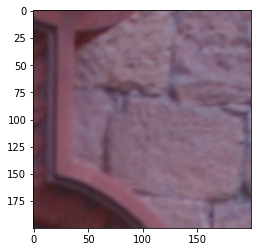

In [10]:
leftImage.showProjectionWindow(cord, windowSize=201)

(1949, 528)
100
1849 2049 428 628
(200, 200, 3)


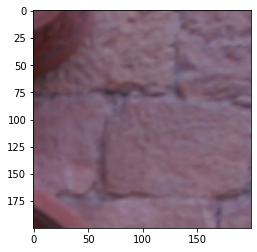

In [11]:
rightImage.showProjectionWindow(cord, windowSize=201)

(1984, 533)
100
1884 2084 433 633
(200, 200, 3)


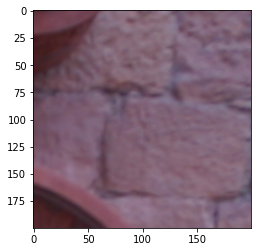

In [12]:
targetImage.showProjectionWindow(cord, windowSize=201)

In [ ]:
# get data -> change them into numpy array -> plot them
image_m = Image.open('./data/0005.png')
image_l = Image.open('./data/0006.png')
image_r = Image.open('./data/0004.png')
data_m, data_l, data_r = np.asarray(image_m), np.asarray(image_l), np.asarray(image_r)
fig = plt.figure(figsize=(18, 6))
ax_l = fig.add_subplot(131)
ax_l.set_title("left")
ax_m = fig.add_subplot(132)
ax_m.set_title("middle")
ax_r = fig.add_subplot(133)
ax_r.set_title("right")
ax_l.imshow(data_l)
ax_m.imshow(data_m)
ax_r.imshow(data_r)

In [ ]:
# define some functions as tools

# get projection matrix:
# ip, ep, cmpos are all type: np.array
def getProjMatrix(ip, ep, cmpos):
    return np.dot(ip, np.hstack((ep, -np.dot(ep, cmpos.reshape((3, 1))))))

# input vector as Cartesian coordinate
# return homogeneous coordinates
# vect: np.array
def getHomoCord(vect):
    if len(vect.shape) == 1: return np.hstack((vect, [1]))
    if len(vect.shape) == 2 and vect.shape[1] == 1: return np.vstack((vect, [[1]]))
    raise ValueError("function getHomoCord must have an input with shape (n,) or (n, 1)")

# input vector is homogeneous coordinate
# return Cartesian coordinate
# vect: np.array
def getCartCord(vect):
    if len(vect.shape) == 1: 
        res, div = np.split(vect, [vect.shape[0] - 1])
        return res / div[0]
    if len(vect.shape) == 2 and vect.shape[1] == 1:
        res, div = np.split(vect, [vect.shape[0] - 1])
        return res / div[0][0]
    raise ValueError("function getCardCord must have an input with shape (n,) or (n, 1)")
    
# input a pixel coordinate
# return if this coordinate in bound
def pixInBound(x, y, res=resolution):
    if 0 < x < res[0] and 0 < y < res[1]: return True
    return False
    
# known pixel coordinate and depth assumption
# return the world coordinate of that assumption point
# x, y, depth: number
# return np.array with shape (3, 1)
def px2WorldCord(x, y, depth, ip=ip, ep=ep_m, cmpos=cmpos_m):
    if depth < 0: 
        raise ValueError("function ps2WorldCord input depth must be greater than 0")
    if not pixInBound(x, y):
        raise ValueError("function px2WorldCord input x and y are out of bounds")
    pix = np.array([x, y, 1]).reshape((3, 1))
    cmCord = np.dot(np.linalg.inv(ip), pix)
    cmCord *= (depth / cmCord[2][0])
    wldCord = np.dot(ep.T, cmCord) + cmpos.reshape((3,1))
    return wldCord

# input a world coordinate, check if this coordinate in bound
def wldCordInBound(wldCord, bound):
    if wldCord.shape == (4,) or wldCord.shape == (4, 1):
        wldCord = wldCord.reshape(4,)
        wldCord = wldCord / wldCord[3]
    return (bound[0][0] < wldCord[0] < bound[0][1] and 
            bound[1][0] < wldCord[1] < bound[1][1] and 
            bound[2][0] < wldCord[2] < bound[2][1])

# input wldCord and projection matrix, get projected pixle_cord
def wldCord2px()

In [ ]:
# calculate the projection matrix
projMatrix_l = getProjMatrix(ip, ep_l, cmpos_l)
projMatrix_m = getProjMatrix(ip, ep_m, cmpos_m)
projMatrix_r = getProjMatrix(ip, ep_r, cmpos_r)

In [ ]:
# main processing
# for each pixle of mid_picture:
#   for each depth_assumption:
#     find worldCord wldCord
#     find wldCord projection on left and right pictures pl, pr
#     use similarity function with window(pl) vs window(rl)
#     

# leftImage, rightImage, targetImage
targetImage.load(leftImage, rightImage)
targetImage.fit(similarityFunction = "", depthRange=(0, 30), planes=100)
targetImage.showDepth()


In [ ]:
np.round(getCartCord(
    np.dot(projMatrix_l, getHomoCord(px2WorldCord(1520, 1006, 7)))
))

In [ ]:
np.round(getCartCord(
np.dot(projMatrix_r, getHomoCord(px2WorldCord(1520, 1006, 7)))
))

In [ ]:
np.round(getCartCord(
    np.dot(projMatrix_m, getHomoCord(px2WorldCord(1520, 1006, 7)))
))

In [ ]:
wldCordInBound(np.array([1,2,3,4]), bound_l)

In [ ]:
np.array([1,2,3,4]).reshape(4,)[3]